# DQN class

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

In [2]:
class Net(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_states, n_hidden)
        self.out = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        actions_value = self.out(x)
        return actions_value

In [3]:
class DQN(object):
    def __init__(self, n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity):
        self.eval_net, self.target_net = Net(n_states, n_actions, n_hidden), Net(n_states, n_actions, n_hidden)

        self.memory = np.zeros((memory_capacity, n_states * 2 + 2)) # 每個 memory 中的 experience 大小為 (state + next state + reward + action)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.memory_counter = 0
        self.learn_step_counter = 0 # 讓 target network 知道什麼時候要更新

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.target_replace_iter = target_replace_iter
        self.memory_capacity = memory_capacity

    def choose_action(self, state, explore = True):
        x = torch.unsqueeze(torch.FloatTensor(state), 0)

        # epsilon-greedy
        if np.random.uniform() < self.epsilon and explore: # 隨機
            action = np.random.randint(0, self.n_actions)
            return action, 1
        else: # 根據現有 policy 做最好的選擇
            actions_value = self.eval_net(x) # 以現有 eval net 得出各個 action 的分數
            action = torch.max(actions_value, 1)[1].data.numpy()[0] # 挑選最高分的 action
            return action, 0

    def store_transition(self, state, action, reward, next_state):
        # 打包 experience
        transition = np.hstack((state, [action, reward], next_state))

        # 存進 memory；舊 memory 可能會被覆蓋
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # 隨機取樣 batch_size 個 experience
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        b_memory = self.memory[sample_index, :]
        b_state = torch.FloatTensor(b_memory[:, :self.n_states])
        b_action = torch.LongTensor(b_memory[:, self.n_states:self.n_states+1].astype(int))
        b_reward = torch.FloatTensor(b_memory[:, self.n_states+1:self.n_states+2])
        b_next_state = torch.FloatTensor(b_memory[:, -self.n_states:])

        # 計算現有 eval net 和 target net 得出 Q value 的落差
        q_eval = self.eval_net(b_state).gather(1, b_action) # 重新計算這些 experience 當下 eval net 所得出的 Q value
        q_next = self.target_net(b_next_state).detach() # detach 才不會訓練到 target net
        q_target = b_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1) # 計算這些 experience 當下 target net 所得出的 Q value
        loss = self.loss_func(q_eval, q_target)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 每隔一段時間 (target_replace_iter), 更新 target net，即複製 eval net 到 target net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_replace_iter == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

# Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time as t
from IPython.display import clear_output
from itertools import islice
import collections
import copy

In [2]:
df = pd.read_csv('log20170629.csv')
df.head()

/Users/jeffreyping/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ip,date,time,zone,cik,accession,extention,code,size,idx,norefer,noagent,find,crawler,browser
0,101.81.133.jja,2017-06-29,00:00:00,0.0,1515671.0,0000940400-17-000412,-index.htm,200.0,6832.0,1.0,0.0,0.0,9.0,0.0,NaN
1,101.81.133.jja,2017-06-29,00:00:00,0.0,1105685.0,0001209191-17-042148,-index.htm,200.0,9902.0,1.0,0.0,0.0,9.0,0.0,NaN
2,101.81.77.ach,2017-06-29,00:00:00,0.0,104894.0,0001193125-10-215678,-index.htm,200.0,7857.0,1.0,0.0,0.0,10.0,0.0,NaN
3,107.23.85.jfd,2017-06-29,00:00:00,0.0,1305479.0,0000905148-06-007070,-index.htm,200.0,2944.0,1.0,0.0,0.0,10.0,0.0,NaN
4,107.23.85.jfd,2017-06-29,00:00:00,0.0,1336279.0,0001193125-07-254842,-index.htm,200.0,2845.0,1.0,0.0,0.0,10.0,0.0,NaN


In [3]:
len(df)

24857817

In [6]:
df2 = pd.DataFrame({'ip':df['ip'], 'time':df['time'], 'size': df['size'], 'one':[1]*len(df)})
df2.head()

,ip,one,size,time
0,101.81.133.jja,1,6832.0,00:00:00
1,101.81.133.jja,1,9902.0,00:00:00
2,101.81.77.ach,1,7857.0,00:00:00
3,107.23.85.jfd,1,2944.0,00:00:00
4,107.23.85.jfd,1,2845.0,00:00:00


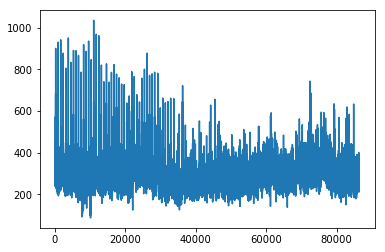

In [7]:
plt.plot(df2.groupby(by='time').sum()['one'].values)#[:40000])
plt.show()

In [139]:
sum(i < 150 for i in df2.groupby(by='time').sum()['one'].values)

109

In [132]:
dfit = pd.DataFrame({'ip':df['ip'], 'time':df['time'], 'one':[1]*len(df)}).drop_duplicates()
pickIp = list(dfit.groupby(by='ip').sum().sort_values(by=['one']).tail(30).index)

In [134]:
df3 = df2[df2['ip'].isin(pickIp)]
df4 = df3.copy()
df4.index = range(len(df4))

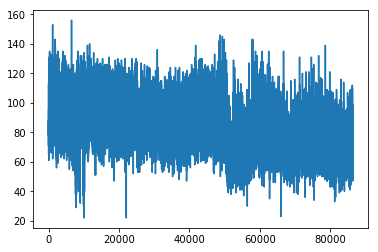

In [135]:
plt.plot(df4.groupby(by='time').sum()['one'].values)
plt.show()

In [140]:
max(df4.groupby(by='time').sum()['one'].values[20000:])

146

In [141]:
pickIp2 = pickIp[:20]
df6 = df2[df2['ip'].isin(pickIp2)]
df7 = df6.copy()
df7.index = range(len(df7))

In [142]:
df4[df4['time'] == '04:00:00'][:5]

,ip,one,size,time
1348761,101.81.133.jja,1,6979.0,04:00:00
1348762,101.81.133.jja,1,6820.0,04:00:00
1348763,165.124.130.igj,1,728305.0,04:00:00
1348764,165.124.130.igj,1,330137.0,04:00:00
1348765,165.124.130.jdj,1,10722.0,04:00:00


In [143]:
df7[df7['time'] == '04:00:00'][:5]

,ip,one,size,time
671923,188.163.72.idh,1,1778.0,04:00:00
671924,188.163.72.idh,1,3269.0,04:00:00
671925,192.223.243.gjc,1,691543.0,04:00:00
671926,192.223.243.gjc,1,649.0,04:00:00
671927,207.241.231.iah,1,637.0,04:00:00


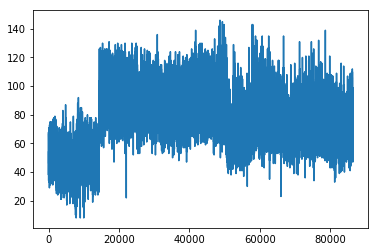

In [144]:
df8 = df7[:671923].append(df4[1348761:])
plt.plot(df8.groupby(by='time').sum()['one'].values)
plt.show()

In [150]:
df9 = df2[df2['ip'].isin(pickIp[20:]) == False]
df10 = df9.copy()
df10.index = range(len(df10))

In [151]:
df10[df10['time'] == '04:00:00'][:5]

,ip,one,size,time
3403302,107.22.225.dea,1,6718.0,04:00:00
3403303,115.114.46.ehd,1,11296.0,04:00:00
3403304,116.231.120.afh,1,7640.0,04:00:00
3403305,116.231.120.afh,1,12547.0,04:00:00
3403306,116.231.120.afh,1,8331.0,04:00:00


In [152]:
df2[df2['time'] == '04:00:00'][:5]

,ip,one,size,time
4080140,101.81.133.jja,1,6979.0,04:00:00
4080141,101.81.133.jja,1,6820.0,04:00:00
4080142,107.22.225.dea,1,6718.0,04:00:00
4080143,115.114.46.ehd,1,11296.0,04:00:00
4080144,116.231.120.afh,1,7640.0,04:00:00


In [153]:
df11 = df10[:3403302].append(df2[4080140:])

In [19]:
df5 = df2.copy()
df5['iptail'] = df5['ip'].apply(lambda x: x[-3:])
alltail = list(set(df5.groupby(by='iptail').first().index))

In [20]:
fixTail = {k: v for v, k in enumerate(alltail)}

In [21]:
len(fixTail)

256

In [22]:
def toBi(num, length):
    bi = bin(num)[2:]
    bi = '0'*length + bi
    bi = bi[-length:]
    return bi

In [23]:
def ipToBi(ip):
    bi = ''
    for i in range(4):
        string = ip.split('.')[i]
        if i != 3:
            bi += toBi(int(string), 8)
        else:
            bi += toBi(fixTail[string], 5)
    return bi

In [24]:
ipToBi('192.223.243.gjc')

'11000000110111111111001110100'

In [25]:
for i in pickIp:
    print(i, ipToBi(i))

192.223.243.gjc 11000000110111111111001110100
94.156.218.jad 01011110100111001101101001001
54.212.94.jcd 00110110110101000101111001111
96.127.52.gig 01100000011111110011010011011
35.161.75.beg 00100011101000010100101111000
66.249.66.chj 01000010111110010100001010110
54.75.252.bfc 00110110010010111111110010110
95.111.49.aed 01011111011011110011000101011
177.66.196.jfc 10110001010000101100010001001
158.132.91.haf 10011110100001000101101110111
207.241.231.iah 11001111111100011110011101000
52.90.157.idh 00110100010110101001110101110
184.56.140.ide 10111000001110001000110011001
68.180.230.ede 01000100101101001110011010111
66.249.66.jjh 01000010111110010100001011111
213.105.134.fjf 11010101011010011000011000110
86.153.144.ihh 01010110100110011001000001010
216.57.159.egd 11011000001110011001111110010
35.167.212.fha 00100011101001111101010011010
188.163.72.idh 10111100101000110100100001110
49.77.227.dfh 00110001010011011110001101100
165.124.130.igj 10100101011111001000001001000
165.124.130.jhd

# HHH class

In [73]:
class Node:

    def __init__(self, data, root = False):

        self.left = None
        self.right = None
        self.data = data
        self.isHH = root
        self.counter = 0
        self.end = False

    def add(self, string: str):
        node = self
        for char in string:
            if char == '0':
                if node.left == None:
                    node.left = Node(node.data + '0')
                node = node.left
            else:
                if node.right == None:
                    node.right = Node(node.data + '1')
                node = node.right
        node.counter += 1
        node.end = True

    def printTree(self):
        if self.left:
            self.left.printTree()
        if self.end:
            print(self.data, self.counter)
        if self.right:
            self.right.printTree()

    def setHH(self, node, threshold):
        if node:
            node.counter += self.setHH(node.left, threshold)
            node.counter += self.setHH(node.right, threshold)
            if node.counter >= threshold:
                node.isHH = True
            else:
                return node.counter
        return 0
    
    def getHH(self, node):
        HH = []
        if node:
            HH = self.getHH(node.left)
            HH = HH + self.getHH(node.right)
            if node.isHH:
                HH.append([node.data, node.counter])
        return HH
    
    def findHH(self, string: str):
        node = self
        hh = node.data
        for char in string:
            if char == '0':
                node = node.left
            else:
                node = node.right
            if not node:
                return hh
            if node.isHH:
                hh = node.data
        return hh

In [74]:
class Trie:

    def __init__(self):

        self.root = Node('', True)
        self.setted = False
    
    def add(self, string):
        self.root.add(string)
        
    def printTrie(self):
        self.root.printTree()
        
    def setHH(self, threshold):
        if self.setted:
            print('Heavy Hitters have been setted')
        else:
            self.root.setHH(self.root, threshold)
            self.setted = True
    
    def getHH(self):
        return self.root.getHH(self.root)
    
    def findHH(self, string):
        if self.setted:
            return self.root.findHH(string)
        else:
            print('Heavy Hitters haven\'t been setted')

In [75]:
trie = Trie()
numList = [20, 3, 15, 7, 5, 5, 43, 2]
for i in range(8):
    for j in range(numList[i]):
        trie.add(('00' + bin(i)[2:])[-3:])
trie.printTrie()
trie.setHH(10)
trie.getHH()

000 20
001 3
010 15
011 7
100 5
101 5
110 43
111 2


[['000', 20], ['010', 15], ['0', 10], ['10', 10], ['110', 43], ['', 2]]

In [76]:
trie.findHH('011')

'0'

# Environment class

In [232]:
class Env(object):
    def __init__(self, df, pickIp, windowSize, maxLoad):
        self.df = df
        self.pickIp = pickIp
        self.windowSize = windowSize
        self.maxLoad = maxLoad
        
        self.enu_df = enumerate(self.df.values)
        self.temp_id, self.temp_row = next(self.enu_df)
        
        self.trie = Trie()
        self.hhh = []
        self.c1 = []
        self.c2 = []
        self.c3 = []
        self.c4 = []
        
    def reset(self):
        self.enu_df = enumerate(self.df.values)
        self.temp_id, self.temp_row = next(self.enu_df)
    
    def diffSec(self, str1, str2):
        return (dt.datetime.strptime(str1, "%H:%M:%S") - dt.datetime.strptime(str2, "%H:%M:%S")).total_seconds()
    
    def train(self, steps):
        
        startTime = self.df.iloc[[self.temp_id]]['time'].values[0]
        
        flag = True
        
        total = 0

        while True:
            
            if flag:
                row_id, row = self.temp_id, self.temp_row
                flag = False
            else:
                row_id, row = next(self.enu_df)
                
            if int(self.diffSec(row[3],startTime)) == self.windowSize*steps:
                self.temp_id, self.temp_row = row_id, row
                self.trie.setHH(total // 15)
                self.hhh = [v[0] for v in self.trie.getHH()]
                self.c1 = [v[1] for v in self.trie.getHH()]
                for i in range(len(self.c1)):
                    if self.c1[i] == 0:
                        self.c1[i] = 1
                self.c2 = [0 for v in range(len(self.c1))]
                return self.hhh
            
            if row[0] in pickIp:
                self.trie.add(ipToBi(row[0]))
                total += 1

            
    def test(self, steps):
        
        score = []
        
        for step in range(steps):
            
            startTime = self.df.iloc[[self.temp_id]]['time'].values[0]
            
            total = 0
            normal = 0
            normalTotal = 0
            self.c4 = [0 for v in range(len(self.c1))]
            self.c3 = [0 for v in range(len(self.c1))]
            
            flag = True
            
            while True:

                if flag:
                    row_id, row = self.temp_id, self.temp_row
                    flag = False
                else:
                    row_id, row = next(self.enu_df)

                if int(self.diffSec(row[3],startTime)) == self.windowSize:
                    self.temp_id, self.temp_row = row_id, row

                    ratio = [x/y for x, y in zip(self.c2, self.c1)]
                    order = [x for _,x in sorted(zip(ratio, self.hhh))]
                    
                    accept = 0
                    cheatNormal = 0
                    acceptList = []
                    for hhh in order:
                        accept += self.c4[self.hhh.index(hhh)]
                        if accept > self.maxLoad:
                            break
                        acceptList.append(hhh)
                        cheatNormal += self.c3[self.hhh.index(hhh)]
                    score.append(cheatNormal/normalTotal)
                        
                    break
                    
                thish = self.trie.findHH(ipToBi(row[0]))
                self.c2[self.hhh.index(thish)] += 1
                self.c4[self.hhh.index(thish)] += 1

                if row[0] in pickIp:
                    normalTotal += 1
                    self.c3[self.hhh.index(thish)] += 1

        return score
            
    
    
    def step(self, action):

        acceptList = []
        for i in range(len(action)):
            if action[i] == 1:
                acceptList.append(self.hhh[i])

            
        startTime = self.df.iloc[[self.temp_id]]['time'].values[0]

        total = 0
        normal = 0
        normalTotal = 0
        
        score = 0

        flag = True

        while True:

            if flag:
                row_id, row = self.temp_id, self.temp_row
                flag = False
            else:
                row_id, row = next(self.enu_df)

            if int(self.diffSec(row[3],startTime)) == self.windowSize:
                self.temp_id, self.temp_row = row_id, row

                if total > self.maxLoad:
                    score = -1
                else:
                    score = normal/normalTotal
                
                return score

            if row[0] in pickIp:
                    normalTotal += 1

            thish = self.trie.findHH(ipToBi(row[0]))

            if thish in acceptList:
                total += 1

                if row[0] in pickIp:
                    normal += 1

    def stepO(self, order):

        startTime = self.df.iloc[[self.temp_id]]['time'].values[0]

        total = 0
        normal = 0
        normalTotal = 0
        self.c4 = [0 for v in range(len(self.c1))]
        self.c3 = [0 for v in range(len(self.c1))]

        flag = True

        while True:

            if flag:
                row_id, row = self.temp_id, self.temp_row
                flag = False
            else:
                row_id, row = next(self.enu_df)

            if int(self.diffSec(row[3],startTime)) == self.windowSize:
                self.temp_id, self.temp_row = row_id, row

                order = [x for _,x in sorted(zip(order, self.hhh))]

                accept = 0
                cheatNormal = 0
                for hhh in order:
                    accept += self.c4[self.hhh.index(hhh)]
                    if accept > self.maxLoad:
                        break
                    cheatNormal += self.c3[self.hhh.index(hhh)]
                return cheatNormal/normalTotal

            thish = self.trie.findHH(ipToBi(row[0]))
            self.c4[self.hhh.index(thish)] += 1

            if row[0] in pickIp:
                normalTotal += 1
                self.c3[self.hhh.index(thish)] += 1

# Original HHH

In [220]:
env = Env(df11, pickIp, 1, 150)
env.train(5000)

['001101',
 '01000',
 '01010110100110011001000001010',
 '0101111',
 '01100000011111110011010011011',
 '10111',
 '11000000110111111111001110100',
 '11011000001110011001111110010',
 '1',
 '']

In [221]:
score = env.test(25000)

In [222]:
scores.append(score)

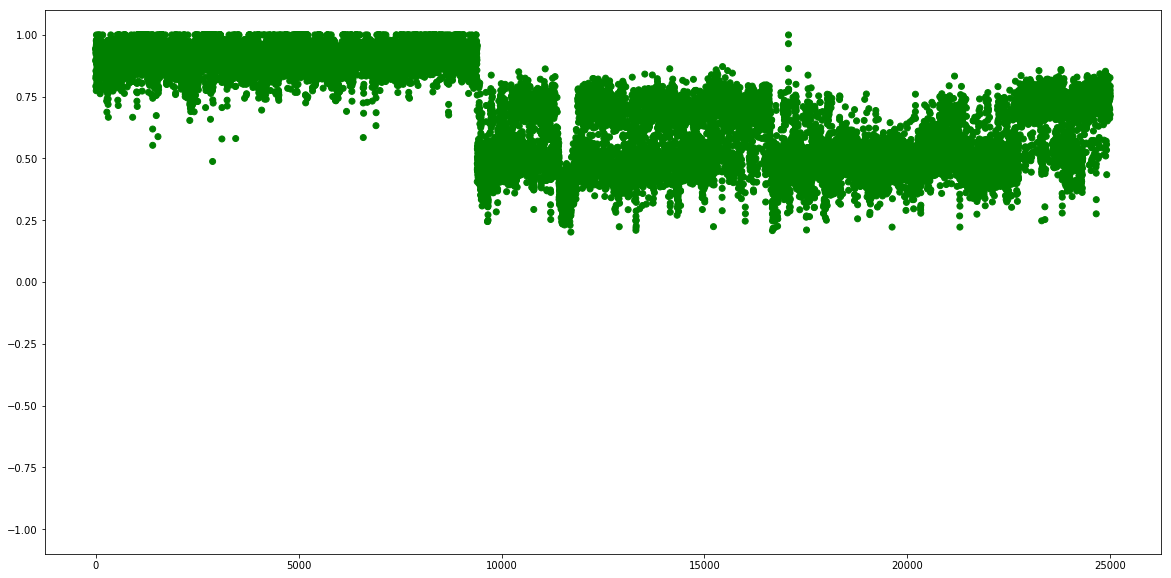

In [224]:
plotReward(scores[0], [0]*len(score))

In [219]:
scores = []

# RL with VFA

In [185]:
env2 = Env(df11, pickIp, 1, 150)
env2.train(5000)

['001101',
 '01000',
 '01010110100110011001000001010',
 '0101111',
 '01100000011111110011010011011',
 '10111',
 '11000000110111111111001110100',
 '11011000001110011001111110010',
 '1',
 '']

In [186]:
state = [1]*len(env2.hhh)

In [187]:
n_actions = 1
n_states = len(state)

n_hidden = 1000
batch_size = 32
lr = 0.01                 
epsilon = 0.02             
gamma = 0.9               
target_replace_iter = 100  
memory_capacity = 1000
steps = 25000

rewardList = []
exploreList = []
stateList = []


dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

for step in range(steps):
    
    s = state[:]
    if np.random.uniform() < epsilon:
        action = np.random.randint(0, len(state) + 1)
        explore = 1
    else:
        next_v = []
        for i in range(len(state)):
            tempS = state[:]
            tempS[i] = (tempS[i] + 1) % 2
            next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(tempS), 0)).data.numpy()[0][0]) 
        next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(s), 0)).data.numpy()[0][0])
        action = np.argmax(next_v)
        explore = 0
    
    if action != len(state):
        state[action] = (state[action] + 1) % 2
    reward = env2.step(state)
    ns = state[:]
    
    dqn.store_transition(s, 0, reward, ns)

    if dqn.memory_counter > 32:
        dqn.learn()
    
    rewardList.append(reward)
    exploreList.append(explore)
    stateList.append(state[:])
    if step % 500 == 0:
        print(action, reward)

2 -1
10 0.5925925925925926
10 0.918918918918919
10 0.8181818181818182
10 0.7906976744186046
10 0.6785714285714286
10 0.6981132075471698
10 0.3698630136986301
10 0.813953488372093
10 0.6
10 1.0
10 0.8909090909090909
10 -1
5 0.7254901960784313
10 0.9347826086956522
10 0.6578947368421053
10 0.8085106382978723
10 0.7666666666666667
10 0.7272727272727273
10 0.42857142857142855
10 0.5365853658536586
10 0.3218390804597701
10 0.3978494623655914
10 0.6263736263736264
10 0.6296296296296297
10 0.5
10 0.5416666666666666
10 0.4943820224719101
10 0.5306122448979592
10 0.5288461538461539
10 0.5903614457831325
10 0.47368421052631576
10 0.36231884057971014
10 0.6222222222222222
10 0.34177215189873417
10 0.52
10 0.5604395604395604
10 0.6923076923076923
10 0.6451612903225806
10 -1
10 0.6352941176470588
3 0.4470588235294118
10 0.48314606741573035
10 0.4444444444444444
10 0.36046511627906974
10 0.4819277108433735
10 0.43137254901960786
10 0.3627450980392157
10 0.4175824175824176
10 0.4574468085106383


In [188]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(exploreList)
results[len(results) - 1].append(exploreList)

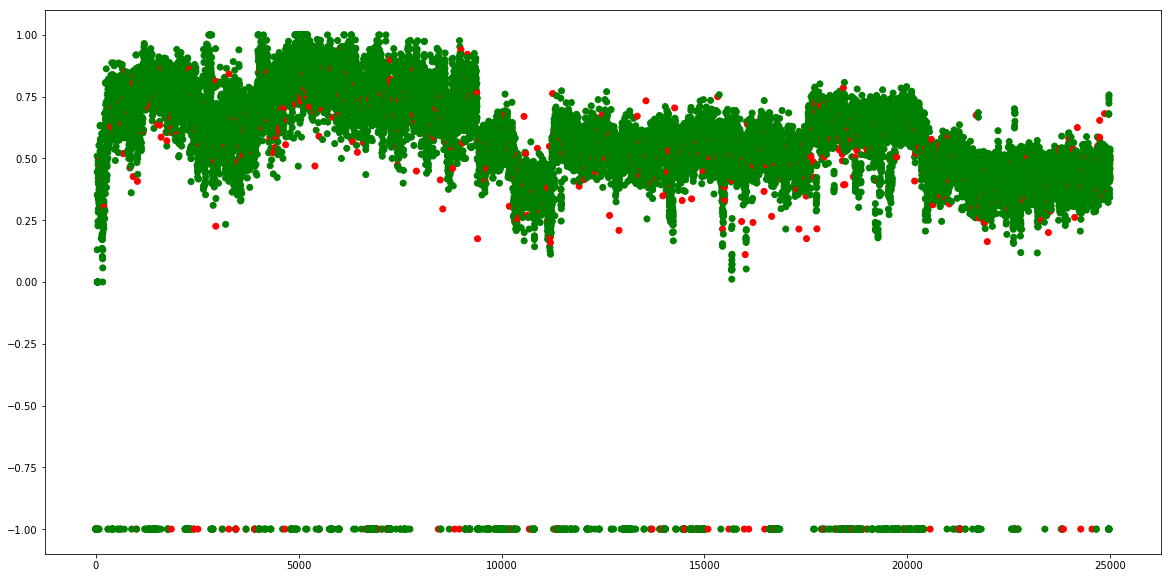

In [190]:
index = 4
plotReward(results[index][0], results[index][1])

In [92]:
results = []

# RL with Order as State (Normalize)

In [227]:
def switch(arr, index):
    array = arr[:]
    temp = array[index]
    array[index] = array[index + 1]
    array[index + 1] = temp
    return array

def norm(state):
    return [x/(len(state) - 1) for x in state]

In [275]:
norm([0,1,2,3])

[0.0, 0.3333333333333333, 0.6666666666666666, 1.0]

In [233]:
env3 = Env(df11, pickIp, 1, 150)
env3.train(5000)

['001101',
 '01000',
 '01010110100110011001000001010',
 '0101111',
 '01100000011111110011010011011',
 '10111',
 '11000000110111111111001110100',
 '11011000001110011001111110010',
 '1',
 '']

In [254]:
state = list(range(len(env2.hhh)))

In [255]:
n_actions = 1
n_states = len(state)

n_hidden = 1000
batch_size = 32
lr = 0.01
epsilon = 0.02
gamma = 0.9
target_replace_iter = 100
memory_capacity = 1000
steps = 25000

rewardList = []
exploreList = []
stateList = []


dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

for step in range(steps):
    
    s = state[:]
    if np.random.uniform() < epsilon:
        action = np.random.randint(0, len(state))
        explore = 1
    else:
        next_v = []
        for i in range(len(state) - 1):
            tempS = norm(switch(s, i))
            next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(tempS), 0)).data.numpy()[0][0]) 
        next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(norm(s)), 0)).data.numpy()[0][0])
        action = np.argmax(next_v)
        explore = 0
    
    if action != len(state) - 1:
        state = switch(state, action)
    reward = env3.stepO(state)
    ns = state[:]
    
    dqn.store_transition(norm(s), 0, reward, norm(ns))

    if dqn.memory_counter > 32:
        dqn.learn()
    
    rewardList.append(reward)
    exploreList.append(explore)
    stateList.append(state[:])
    if step % 500 == 0:
        print(action, reward)

2 0.8947368421052632
9 0.8518518518518519
9 0.972972972972973
9 0.9090909090909091
9 0.9302325581395349
9 0.9642857142857143
9 0.9811320754716981
9 0.9863013698630136
9 1.0
9 0.9555555555555556
9 1.0
9 0.9636363636363636
9 0.875
9 0.9411764705882353
9 0.9782608695652174
9 0.9736842105263158
9 0.9361702127659575
9 0.95
9 0.8484848484848485
9 0.5952380952380952
9 0.7317073170731707
9 0.7126436781609196
9 0.5053763440860215
9 0.04395604395604396
9 0.5555555555555556
9 0.7023809523809523
0 0.7361111111111112
9 0.47191011235955055
9 0.46938775510204084
9 0.5192307692307693
9 0.5060240963855421
9 0.7894736842105263
9 0.5942028985507246
9 0.7222222222222222
9 0.379746835443038
9 0.4266666666666667
9 0.31868131868131866
9 0.5384615384615384
9 0.4731182795698925
9 0.44
9 0.6
9 0.5411764705882353
9 0.5617977528089888
9 0.4444444444444444
9 0.6976744186046512
9 0.4457831325301205
9 0.7549019607843137
9 0.7549019607843137
9 0.4835164835164835
9 0.7872340425531915


In [257]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(exploreList)
results[len(results) - 1].append(exploreList)

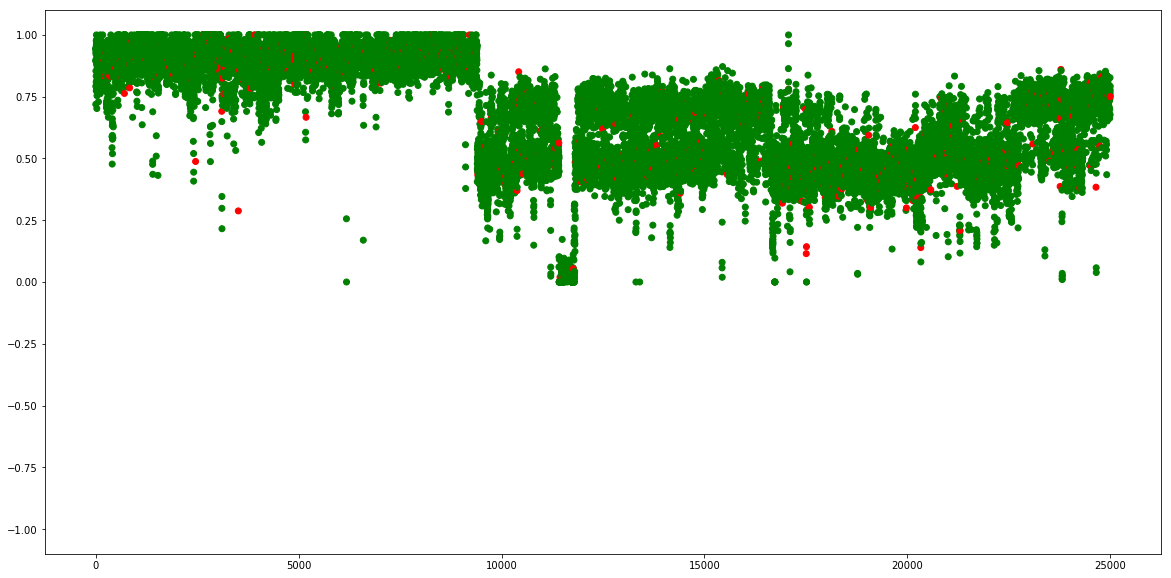

In [258]:
index = 0
plotReward(results[index][0], results[index][1])

In [256]:
results = []

# RL with Order as State (one-hot)

In [246]:
def switch(arr, index):
    array = arr[:]
    temp = array[index]
    array[index] = array[index + 1]
    array[index + 1] = temp
    return array

def OneHot(state):
    l = len(state)
    oh = [0]*(l*l)
    off = 0
    for i in state:
        oh[i + off] = 1
        off += l
    return oh

In [247]:
OneHot([1,3,0,2])

[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]

In [260]:
env4 = Env(df11, pickIp, 1, 150)
env4.train(5000)

['001101',
 '01000',
 '01010110100110011001000001010',
 '0101111',
 '01100000011111110011010011011',
 '10111',
 '11000000110111111111001110100',
 '11011000001110011001111110010',
 '1',
 '']

In [262]:
state = list(range(len(env4.hhh)))

In [263]:
n_actions = 1
n_states = len(state)**2

n_hidden = 1000
batch_size = 32
lr = 0.01
epsilon = 0.02
gamma = 0.9
target_replace_iter = 100
memory_capacity = 1000
steps = 25000

rewardList2 = []
exploreList2 = []
stateList2 = []


dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

for step in range(steps):
    
    s = state[:]
    if np.random.uniform() < epsilon:
        action = np.random.randint(0, len(state))
        explore = 1
    else:
        next_v = []
        for i in range(len(state) - 1):
            tempS = OneHot(switch(s, i))
            next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(tempS), 0)).data.numpy()[0][0]) 
        next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(OneHot(s)), 0)).data.numpy()[0][0])
        action = np.argmax(next_v)
        explore = 0
    
    if action != len(state) - 1:
        state = switch(state, action)
    reward = env4.stepO(state)
    ns = state[:]
    
    dqn.store_transition(OneHot(s), 0, reward, OneHot(ns))

    if dqn.memory_counter > 32:
        dqn.learn()
    
    rewardList2.append(reward)
    exploreList2.append(explore)
    stateList2.append(state[:])
    if step % 500 == 0:
        print(action, reward)

1 0.8947368421052632
3 0.8518518518518519
9 0.972972972972973
9 0.9090909090909091
9 0.9302325581395349
9 0.9642857142857143
9 0.9811320754716981
9 0.9863013698630136
9 1.0
5 0.9555555555555556
9 1.0
5 0.9636363636363636
9 0.875
9 0.9411764705882353
9 0.9782608695652174
3 0.9210526315789473
9 0.9361702127659575
9 0.95
9 0.7272727272727273
9 0.5952380952380952
9 0.7317073170731707
9 0.7126436781609196
9 0.46236559139784944
7 0.08791208791208792
9 0.5555555555555556
9 0.7023809523809523
0 0.7361111111111112
9 0.47191011235955055
7 0.46938775510204084
9 0.5192307692307693
9 0.5060240963855421
4 0.7894736842105263
9 0.5942028985507246
9 0.7222222222222222
9 0.379746835443038
9 0.4266666666666667
9 0.3626373626373626
9 0.5673076923076923
9 0.4731182795698925
9 0.49
9 0.5294117647058824
9 0.43529411764705883
9 0.6179775280898876
9 0.6419753086419753
9 0.6627906976744186
2 0.6265060240963856
9 0.6862745098039216
9 0.7450980392156863
9 0.31868131868131866
9 0.7659574468085106


In [265]:
results2.append([])
results2[len(results) - 1].append(rewardList2)
results2[len(results) - 1].append(exploreList2)
results2[len(results) - 1].append(stateList2)

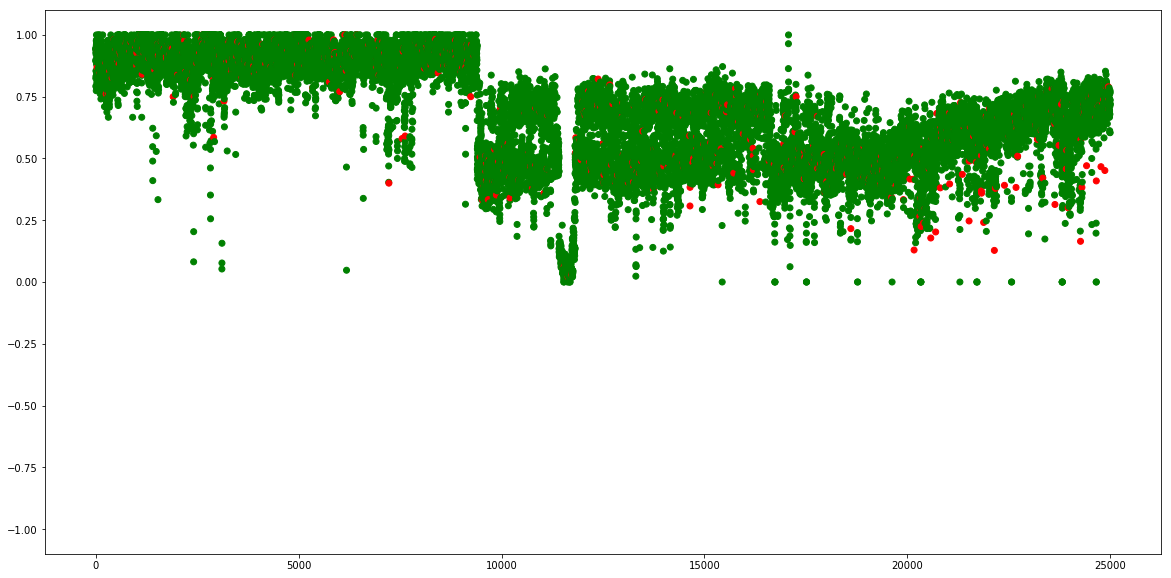

In [266]:
index = 0
plotReward(results2[index][0], results2[index][1])

In [264]:
results2 = []

# Plot 

In [269]:
def toColor(num):
    colors = ['green', 'red', 'blue']
    return colors[num]

def plotReward(rewardList, exploreList):
    plt.figure(figsize=(20,10))
    plt.ylim(-1.1, 1.1)
    plt.scatter(range(len(rewardList)), rewardList, color = list(map(toColor, exploreList)))
    plt.show()
    
def plotLines(lists, labels):
    plt.figure(figsize=(15,7.5))
    plt.ylim(-1.1, 1.1)
    
    for i in range(len(lists)):
        acc = []
        s = 0
        for j in range(len(lists[i])):
            s += lists[i][j]
            if j % 100 == 0 and j != 0:
                acc.append(s/100)
                s = 0
        plt.plot(acc, color = toColor(i), label = labels[i], alpha=0.7)
    
    plt.xlabel('Time (100s)', fontsize=15)
    plt.ylabel('Legitimate (%)', fontsize=15)
    
    plt.legend(loc=4, prop={'size': 20})
    plt.show()

# First

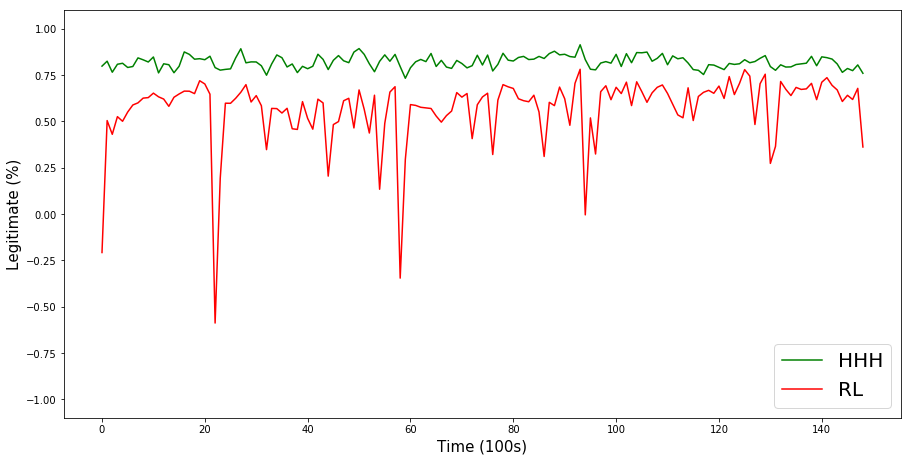

In [379]:
plotLines([scores[0], results[0][0]], ['HHH', 'RL'])

# Flush

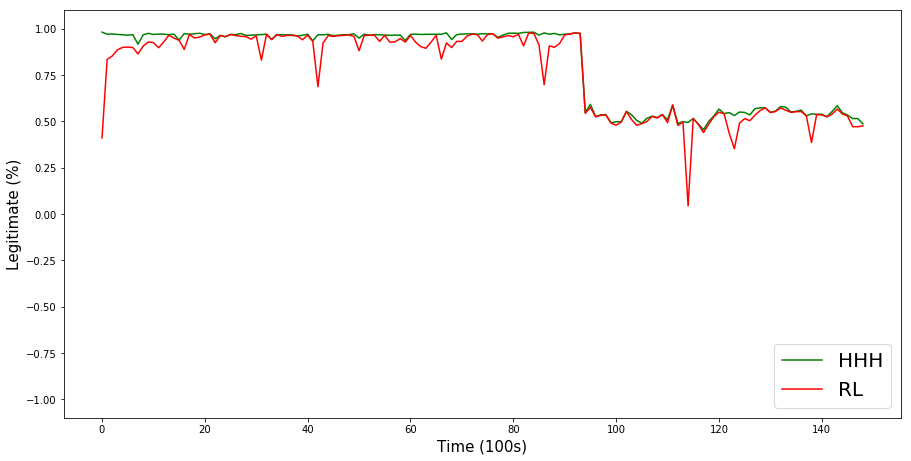

In [192]:
num = 0
plotLines([scores[num], results[num][0]], ['HHH', 'RL'])

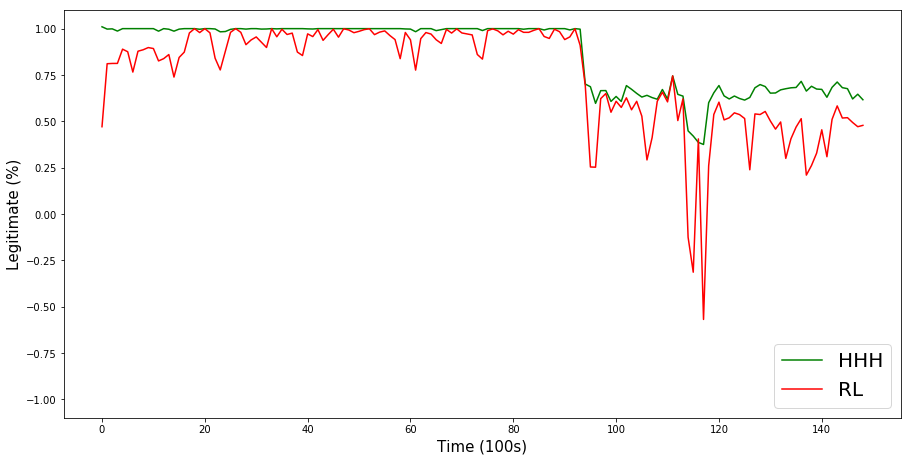

In [193]:
num = 1
plotLines([scores[num], results[num][0]], ['HHH', 'RL'])

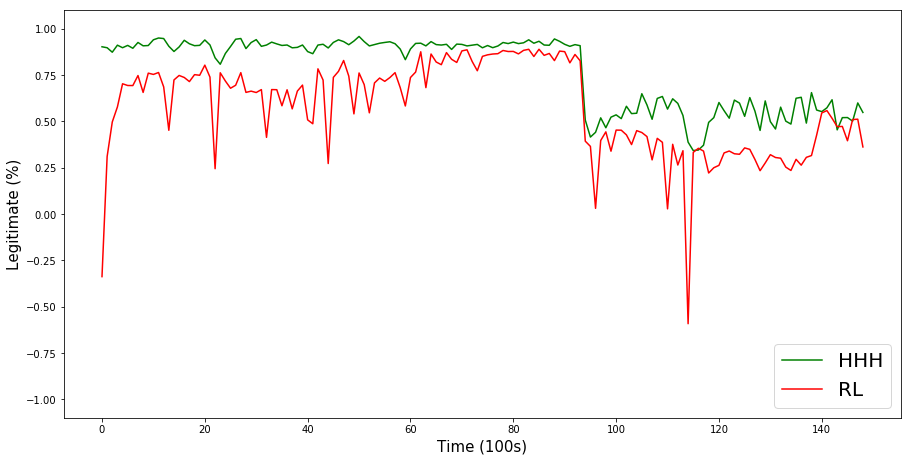

In [194]:
num = 2
plotLines([scores[num], results[num][0]], ['HHH', 'RL'])

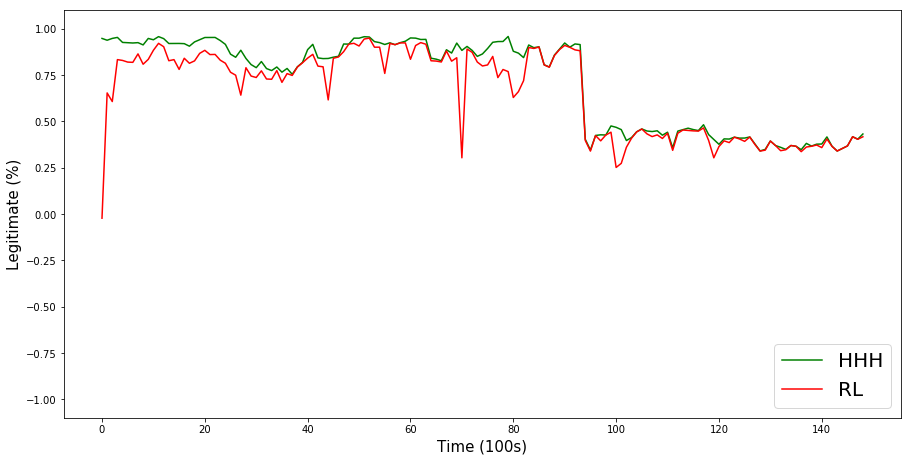

In [195]:
num = 3
plotLines([scores[num], results[num][0]], ['HHH', 'RL'])

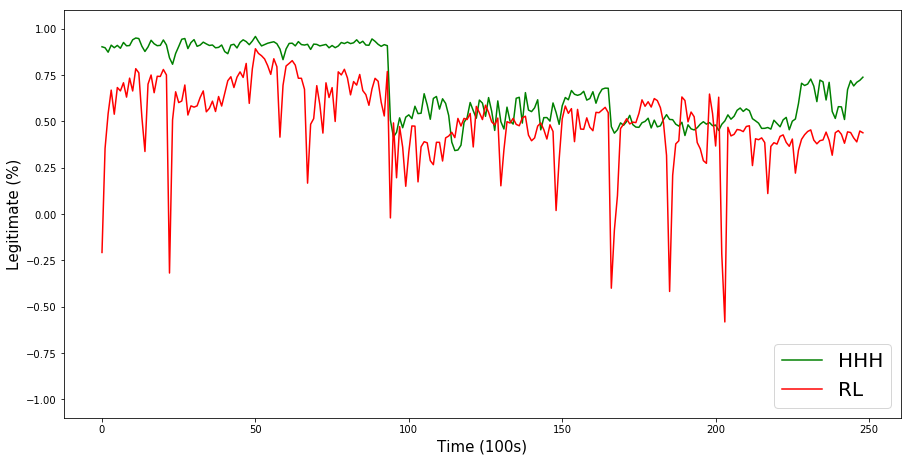

In [191]:
num = 4
plotLines([scores[num], results[num][0]], ['HHH', 'RL'])

# Order

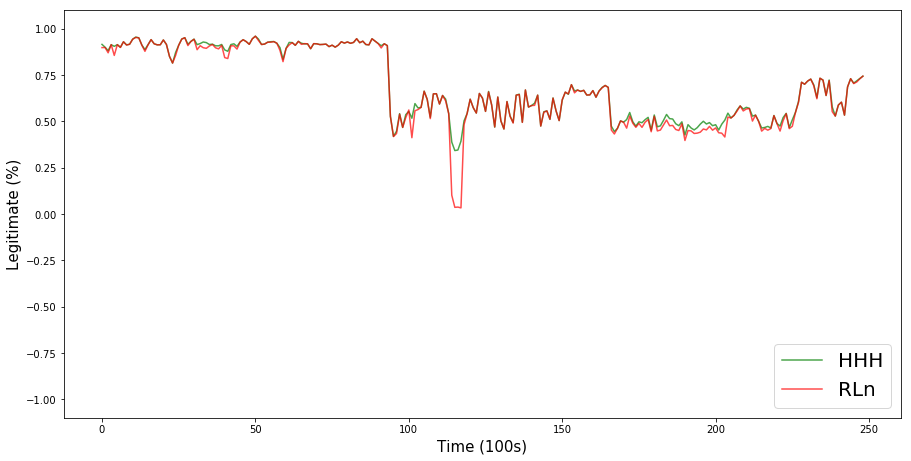

In [271]:
num = 0
plotLines([scores[num], results[num][0]], ['HHH', 'RLn'])

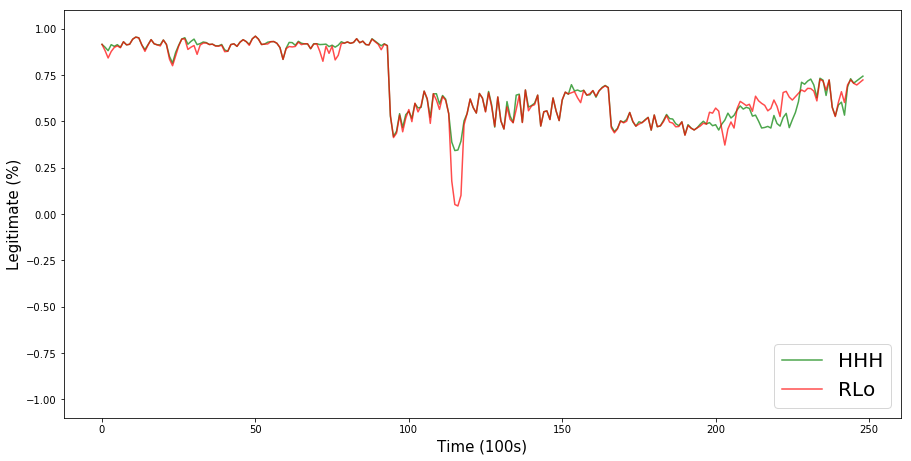

In [272]:
num = 0
plotLines([scores[num], results2[num][0]], ['HHH', 'RLo'])

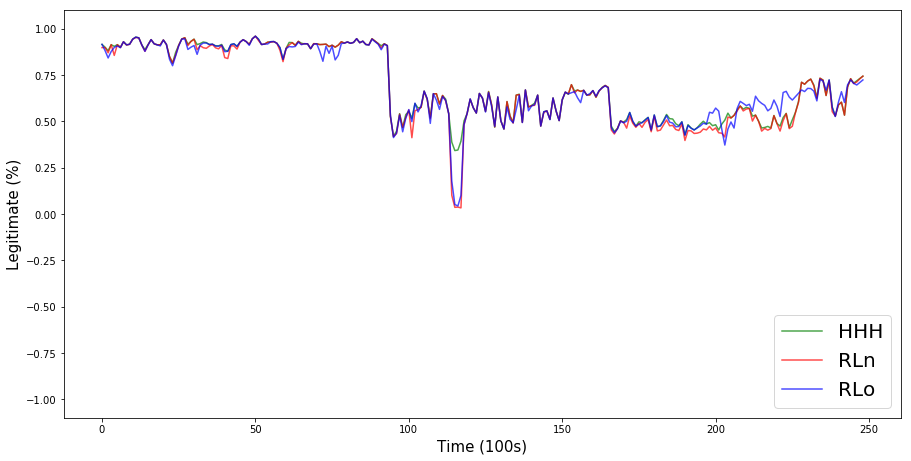

In [273]:
num = 0
plotLines([scores[num], results[num][0], results2[num][0]], ['HHH', 'RLn', 'RLo'])